# Transmission spectra

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import iris.cube
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

In [3]:
from tqdm.notebook import tqdm

In [4]:
# My packages and local scripts
from aeolus.calc import time_mean
from aeolus.const import init_const
from aeolus.coord import isel
from aeolus.core import AtmoSim
from aeolus.io import load_data, load_vert_lev
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from aeolus.region import Region
from aeolus.synthobs import (
    calc_stellar_flux,
    calc_transmission_spectrum,
    read_normalized_stellar_flux,
    read_spectral_bands,
)

In [5]:
from pouch.path import lsdir
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    figsave,
    use_style,
)

In [6]:
import mypaths
from commons import GLM_MODEL_TIMESTEP, GLM_SUITE_ID, NIGHTSIDE, SIM_LABELS

In [7]:
use_style()

In [8]:
# SELECTED_SIM = {k: v for k, v in {**SIM}.items() if k in ["hab1", "hab2"]}
img_prefix = f"{GLM_SUITE_ID}_synthobs"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_synthobs"
time_prof = "synthobs"
plotdir = mypaths.plotdir / img_prefix

In [9]:
RAD_OPT_LABELS = {
    #     "dsa_mcica_lowres": {
    #         "title": "DSA low-res; MCICA",
    #         "kw_plt": {"color": "C0"},
    #         "spectral_file_sw": mypaths.home / "spectral" / "trappist1" / "dsa" / "sp_sw_21_dsa_trappist1"
    #     },
    # "ga9_mcica_hybrid": {
    #     "title": "GA9 hybrid; MCICA",
    #     "kw_plt": {"color": "C0"},
    #     "spectral_file_sw": mypaths.home / "spectral" / "trappist1" / "ga9_hybrid" / "sp_sw_260_jm3_trappist1"
    # },
    "dsa_mcica_hybrid": {
        "title": "DSA hybrid; MCICA",
        "kw_plt": {"color": "C1"},
        "spectral_file_sw": mypaths.home
        / "spectral"
        / "trappist1"
        / "dsa_hybrid"
        / "sp_sw_280_dsa_trappist1",
    },
    #     "dsa_scaled_cloud_lowres": {
    #         "title": "DSA low-res; scaling factor",
    #         "kw_plt": {"color": "C2"},
    #         "spectral_file_sw": mypaths.home / "spectral" / "trappist1" / "dsa" / "sp_sw_21_dsa_trappist1"
    #     },
    #     "dsa_scaled_cloud_highres": {
    #         "title": "DSA high-res; scaling factor",
    #         "kw_plt": {"color": "C3"},
    #         "spectral_file_sw": mypaths.home / "spectral" / "trappist1" / "dsa_hr" / "sp_sw_280_dsa_trappist1"
    #     },
}

In [10]:
rad_opt_label = "dsa_mcica_hybrid"

In [22]:
sim_label_a, sim_label_b = SIM_LABELS.keys()

In [11]:
# Load processed data
runs = {}
for sim_label, sim_prop in tqdm(SIM_LABELS.items()):
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=sim_prop["planet"],
        const_dir=mypaths.constdir,
        model=um,
        vert_coord=None,
    )
    runs[sim_label].theta_levels = iris.cube.Cube(
        data=load_vert_lev(mypaths.home / "vert" / "vertlevs_L38_29t_9s_80km"),
        units="m",
        long_name="level_height",
    )
    runs[sim_label].spectral_file_sw = RAD_OPT_LABELS["dsa_mcica_hybrid"][
        "spectral_file_sw"
    ]

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
VRBL_PLOT = {
    "cloudy": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i555"),
        "title": "Cloudy",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"linestyle": "-", "alpha": 1}
        # "kw_plt": {"linestyle": "-", "lw": 4, "alpha":0.25},
    },
    "clear": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i556"),
        "title": "Clear-sky",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"linestyle": "--", "dash_capstyle": "round"},
    },
}

In [13]:
RESULTS = {}
for sim_label in SIM_LABELS.keys():
    the_run = runs[sim_label]
    planet_top_of_atmosphere = the_run.const.radius + the_run.theta_levels[-1]
    stellar_constant_at_1_au = (
        the_run.const.solar_constant
        * (the_run.const.semi_major_axis / iris.cube.Cube(data=1, units="au")) ** 2
    )
    RESULTS[sim_label] = {}
    for (vrbl_key, vrbl_dict) in VRBL_PLOT.items():
        cube = vrbl_dict["cube"](the_run)
        cube.units = tex2cf_units(vrbl_dict["tex_units"])
        # cube.convert_units(tex2cf_units(vrbl_dict["tex_units"]))
        RESULTS[sim_label][vrbl_key] = (
            calc_transmission_spectrum(
                cube,
                the_run.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run.model,
            )
            ** 2
        )

### Main plot

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved to ../plots/ch111_synthobs/ch111_synthobs__base_sens-t280k__cloudy_clear.png


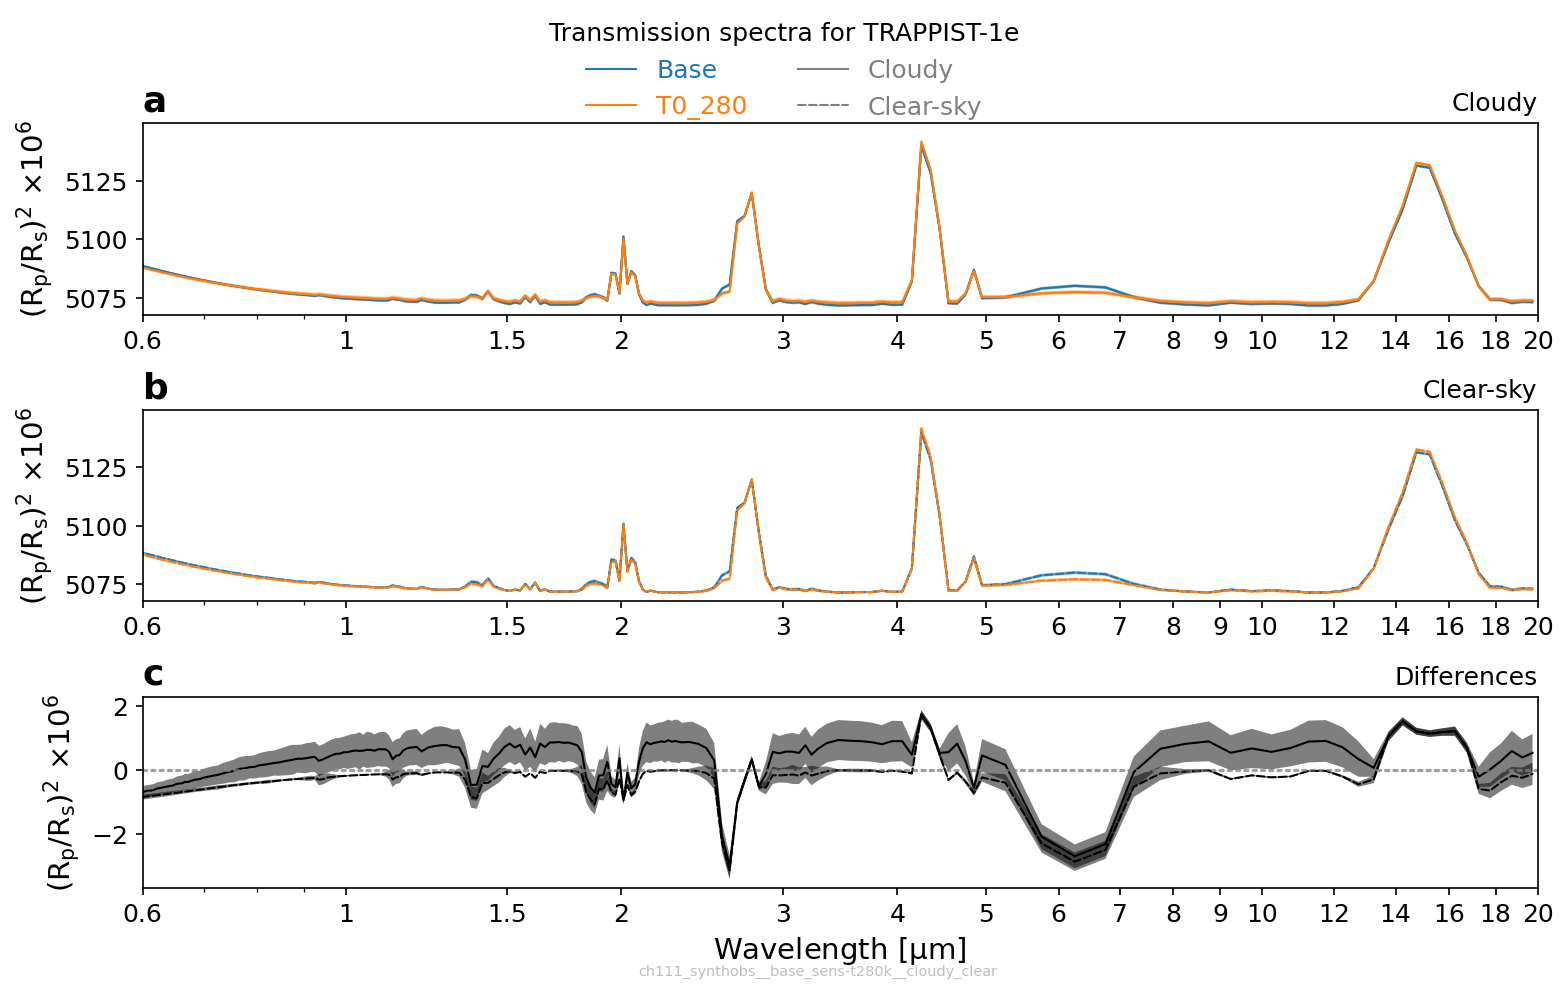

In [17]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__{'_'.join(VRBL_PLOT.keys())}"
kw_plt_common = {"lw": 1.0}  # marker=".",        ms=3,

fig = plt.figure()
axd = fig.subplot_mosaic(
    [[i] for i in [*VRBL_PLOT.keys(), "diff"]], gridspec_kw={"hspace": 0.5}
)
iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
        # ax.set_ylabel("Transmission\ndepth [ppm]")

    ax.set_xscale("log")
    xticks = np.concatenate([[0.6, 1, 1.5], np.arange(2, 10, 1), np.arange(10, 22, 2)])
    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: f"{int(x):d}" if int(x) == x else f"{x:.1f}"
        )
    )
    ax.set_xlim(xticks.min(), xticks.max())

for (vrbl_key, vrbl_dict) in tqdm(VRBL_PLOT.items()):
    for sim_label, sim_prop in tqdm(SIM_LABELS.items()):
        cube_mean = time_mean(RESULTS[sim_label][vrbl_key])
        cube_std = (RESULTS[sim_label][vrbl_key]).collapsed(um.t, iris.analysis.STD_DEV)
        x = cube_mean.coord("spectral_band_centres")
        axd[vrbl_key].fill_between(
            x.points * 1e6,
            (cube_mean - cube_std).data * 1e6,
            (cube_mean + cube_std).data * 1e6,
            alpha=0.5,
            **sim_prop["kw_plt"],
        )
        axd[vrbl_key].plot(
            x.points * 1e6,
            cube_mean.data * 1e6,
            **kw_plt_common,
            **sim_prop["kw_plt"],
            **vrbl_dict["kw_plt"],
        )

# Difference
for (vrbl_key, vrbl_dict) in tqdm(VRBL_PLOT.items()):
    cube_diff = RESULTS[sim_label_b][vrbl_key] - RESULTS[sim_label_a][vrbl_key]
    cube_mean = time_mean(cube_diff)
    cube_std = cube_diff.collapsed(um.t, iris.analysis.STD_DEV)

    x = cube_diff.coord("spectral_band_centres")
    axd["diff"].fill_between(
        x.points * 1e6,
        (cube_mean - cube_std).data * 1e6,
        (cube_mean + cube_std).data * 1e6,
        alpha=0.5,
        color="k",
        linewidth=0,
    )
    axd["diff"].plot(
        x.points * 1e6,
        cube_mean.data * 1e6,
        color="k",
        **kw_plt_common,
        **vrbl_dict["kw_plt"],
    )
    axd["diff"].axhline(0, **KW_ZERO_LINE)


add_custom_legend(
    fig,
    {
        **{v["title"]: {**kw_plt_common, **v["kw_plt"]} for v in SIM_LABELS.values()},
        **{
            v["title"]: {**kw_plt_common, "color": "tab:grey", **v["kw_plt"]}
            for v in VRBL_PLOT.values()
        },
    },
    loc="upper center",
    frameon=False,
    ncol=2,
    fontsize="medium",
    title="Transmission spectra for TRAPPIST-1e",
)

axd["cloudy"].set_title(
    "Cloudy",
    loc="right",
    size="medium",
)
axd["clear"].set_title(
    "Clear-sky",
    loc="right",
    size="medium",
)
axd["diff"].set_title(
    "Differences",
    loc="right",
    size="medium",
)

figsave(fig, plotdir / imgname)

### Terminator differences

In [18]:
TERMINATORS = {
    "west_term": {
        "constraint": Region(180, 360, -90, 90).constraint,
        "title": "Western (morning) terminator",
        "label": "west_term",
        "kw_plt": dict(linestyle="-"),
    },
    "east_term": {
        "constraint": Region(0, 180, -90, 90).constraint,
        "title": "Eastern (evening) terminator",
        "label": "east_term",
        "kw_plt": dict(linestyle="--"),
    },
}

In [19]:
VRBL_PLOT = {
    "cloudy": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i555"),
        "title": "Cloudy",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"color": "tab:pink"},
    },
    "clear": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i556"),
        "title": "Clear-sky",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"color": "tab:cyan"},
    },
    "dry": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i756"),
        "title": "Dry",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"color": "tab:olive"},
    },
}

#### Case by case

In [20]:
TERM_DIFF = {}
for sim_label in SIM_LABELS.keys():
    the_run = runs[sim_label]
    planet_top_of_atmosphere = the_run.const.radius + the_run.theta_levels[-1]
    stellar_constant_at_1_au = (
        the_run.const.solar_constant
        * (the_run.const.semi_major_axis / iris.cube.Cube(data=1, units="au")) ** 2
    )
    TERM_DIFF[sim_label] = {}
    for (vrbl_key, vrbl_prop) in VRBL_PLOT.items():
        TERM_DIFF[sim_label][vrbl_key] = {}
        cube = vrbl_prop["cube"](the_run)
        cube.units = tex2cf_units(vrbl_prop["tex_units"])
        cube_west = (
            calc_transmission_spectrum(
                cube.extract(TERMINATORS["west_term"]["constraint"]),
                the_run.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run.model,
            )
            ** 2
        )
        cube_east = (
            calc_transmission_spectrum(
                cube.extract(TERMINATORS["east_term"]["constraint"]),
                the_run.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run.model,
            )
            ** 2
        )
        TERM_DIFF[sim_label][vrbl_key] = cube_east - cube_west

Saved to ../plots/ch111_synthobs/ch111_synthobs__east_minus_west__base_sens-t280k__cloudy_clear_dry.png


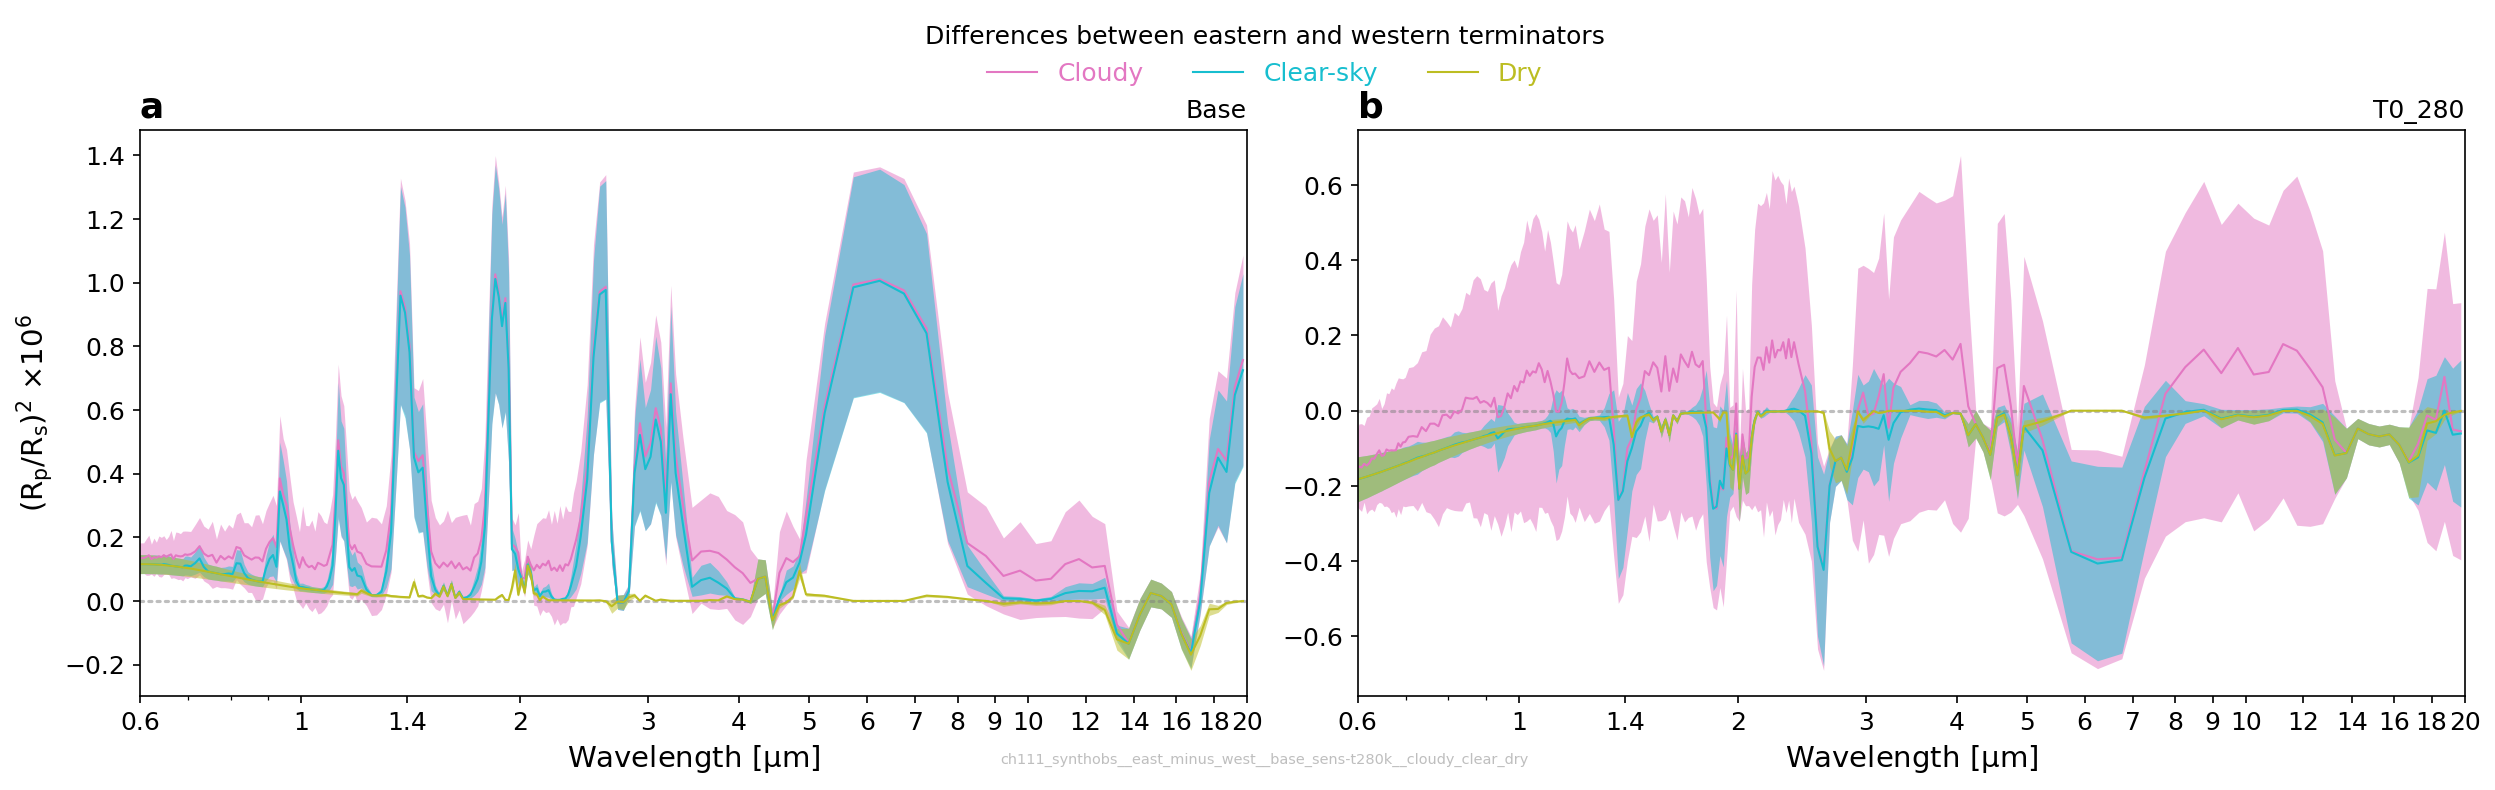

In [21]:
imgname = f"{img_prefix}__east_minus_west__{'_'.join(SIM_LABELS.keys())}__{'_'.join(VRBL_PLOT.keys())}"
kw_plt_common = {"lw": 1.0}

fig = plt.figure(figsize=(20, 5))

axd = fig.subplot_mosaic([[*SIM_LABELS.keys()]], gridspec_kw={"wspace": 0.1})

iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")
    ax.axhline(0, **KW_ZERO_LINE)
    xticks = np.concatenate([[0.6, 1, 1.4], np.arange(2, 10, 1), np.arange(10, 22, 2)])
    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: f"{int(x):d}" if int(x) == x else f"{x:.1f}"
        )
    )
    ax.set_xlim(xticks.min(), xticks.max())

for sim_label in SIM_LABELS.keys():
    ax = axd[sim_label]
    ax.set_title(
        SIM_LABELS[sim_label]["title"],
        loc="right",
        size="medium",
    )

    for vrbl_key, vrbl_prop in VRBL_PLOT.items():
        cube_mean = time_mean(TERM_DIFF[sim_label][vrbl_key])
        cube_std = (TERM_DIFF[sim_label][vrbl_key]).collapsed(
            um.t, iris.analysis.STD_DEV
        )
        x = cube_mean.coord("spectral_band_centres")
        ax.fill_between(
            x.points * 1e6,
            (cube_mean - cube_std).data * 1e6,
            (cube_mean + cube_std).data * 1e6,
            alpha=0.5,
            linewidth=0,
            **vrbl_prop["kw_plt"],
        )
        ax.plot(
            x.points * 1e6,
            cube_mean.data * 1e6,
            **kw_plt_common,
            **vrbl_prop["kw_plt"],
        )

add_custom_legend(
    fig,
    {
        **{v["title"]: {**kw_plt_common, **v["kw_plt"]} for v in VRBL_PLOT.values()},
    },
    loc="upper center",
    frameon=False,
    ncol=len(VRBL_PLOT),
    fontsize="medium",
    title="Differences between eastern and western terminators",
    bbox_to_anchor=(0.5, 1.05),
)

figsave(fig, plotdir / imgname)

#### Terminator by terminator

In [23]:
sim_label_a, sim_label_b = SIM_LABELS.keys()
TERM_DIFF = {}
the_run_a = runs[sim_label_a]
planet_top_of_atmosphere = the_run_a.const.radius + the_run_a.theta_levels[-1]
stellar_constant_at_1_au = (
    the_run_a.const.solar_constant
    * (the_run_a.const.semi_major_axis / iris.cube.Cube(data=1, units="au")) ** 2
)
the_run_b = runs[sim_label_b]

for (vrbl_key, vrbl_prop) in VRBL_PLOT.items():
    TERM_DIFF[vrbl_key] = {}
    cube_a = vrbl_prop["cube"](the_run_a)
    cube_a.units = tex2cf_units(vrbl_prop["tex_units"])
    cube_b = vrbl_prop["cube"](the_run_b)
    cube_b.units = tex2cf_units(vrbl_prop["tex_units"])
    for term_key, term_prop in TERMINATORS.items():
        cube_trans_a = (
            calc_transmission_spectrum(
                cube_a.extract(term_prop["constraint"]),
                the_run_a.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run_a.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run_a.model,
            )
            ** 2
        )
        cube_trans_b = (
            calc_transmission_spectrum(
                cube_b.extract(term_prop["constraint"]),
                the_run_b.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run_b.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run_b.model,
            )
            ** 2
        )
        TERM_DIFF[vrbl_key][term_key] = cube_trans_b - cube_trans_a

Saved to ../plots/ch111_synthobs/ch111_synthobs__sens-t280k_minus_base__dsa_mcica_hybrid__cloudy_clear_dry.png


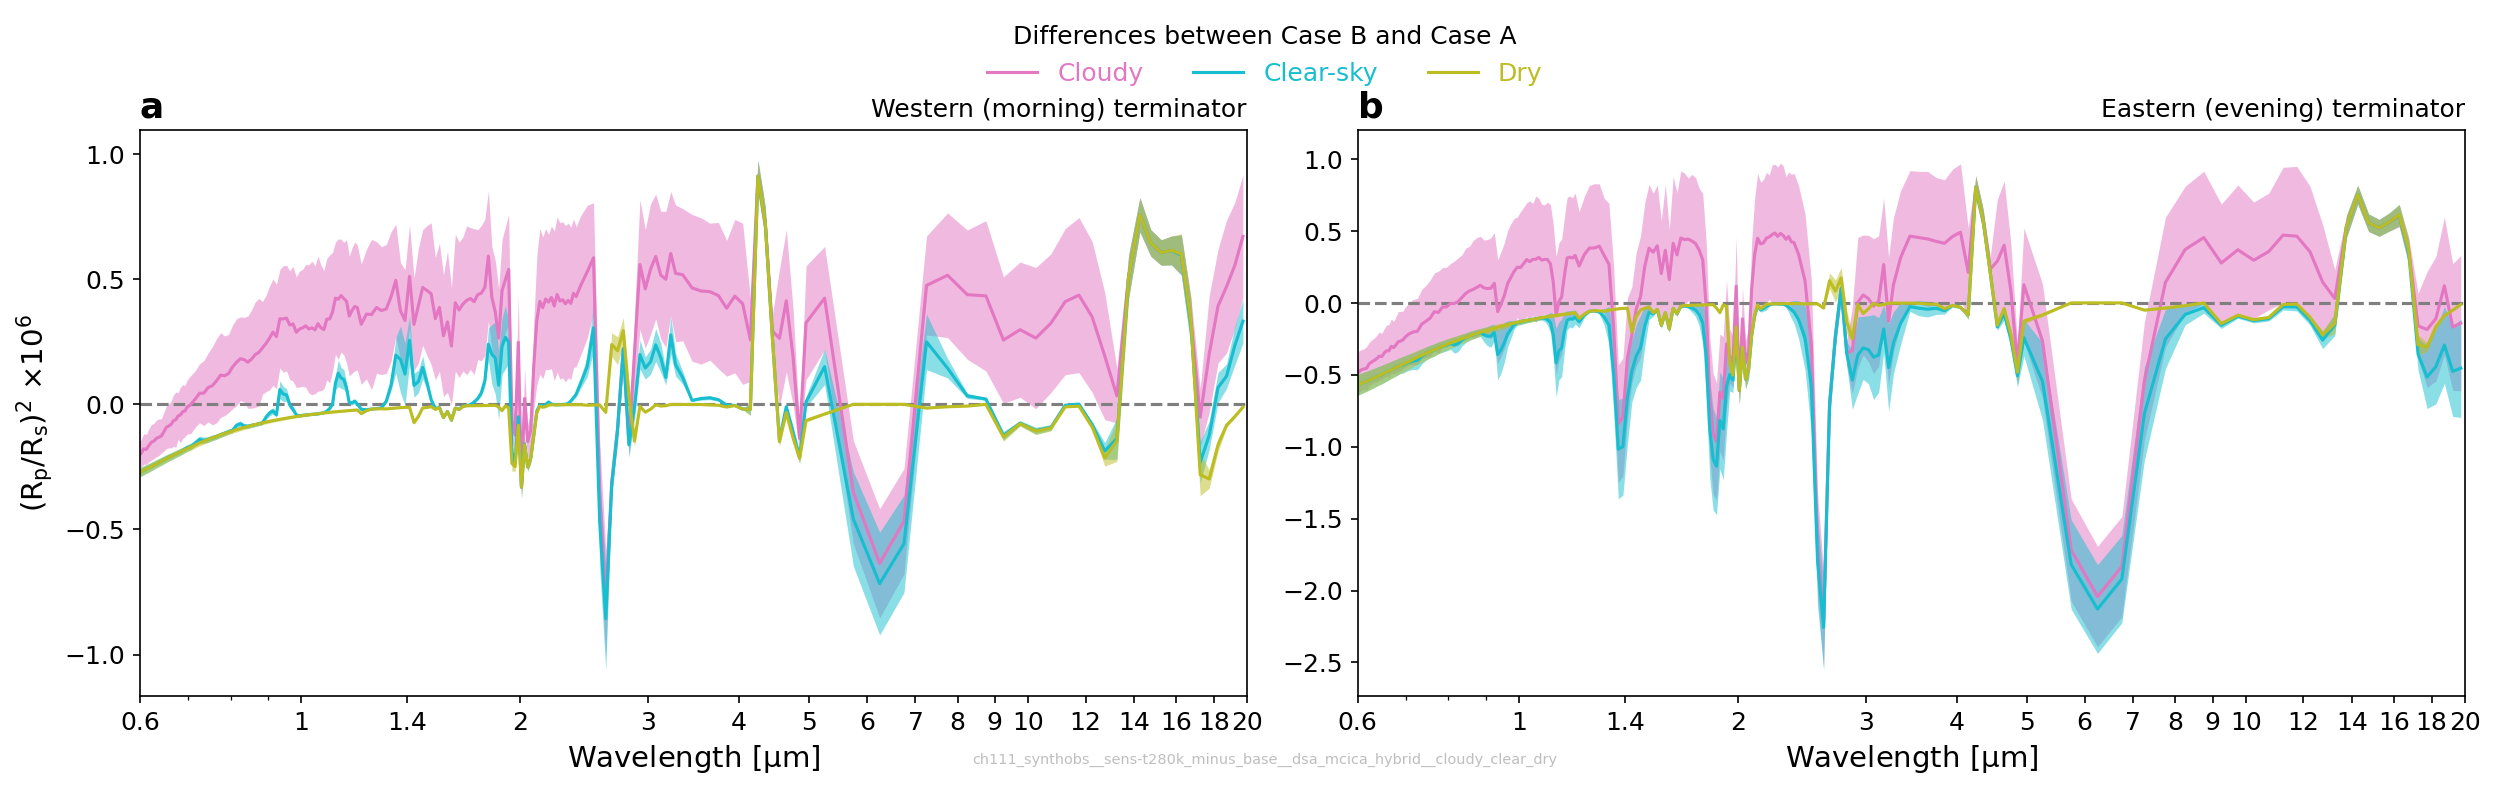

In [24]:
imgname = f"{img_prefix}__{sim_label_b}_minus_{sim_label_a}__{rad_opt_label}__{'_'.join(VRBL_PLOT.keys())}"
kw_plt_common = {}

fig = plt.figure(figsize=(20, 5))

axd = fig.subplot_mosaic([[*TERMINATORS.keys()]], gridspec_kw={"wspace": 0.1})

iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")
    ax.axhline(0, linestyle="--", color="tab:grey")
    xticks = np.concatenate([[0.6, 1, 1.4], np.arange(2, 10, 1), np.arange(10, 22, 2)])
    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: f"{int(x):d}" if int(x) == x else f"{x:.1f}"
        )
    )
    ax.set_xlim(xticks.min(), xticks.max())

for term_key in TERMINATORS.keys():
    ax = axd[term_key]
    ax.set_title(
        TERMINATORS[term_key]["title"],
        loc="right",
        size="medium",
    )

    for vrbl_key, vrbl_prop in VRBL_PLOT.items():
        cube_mean = time_mean(TERM_DIFF[vrbl_key][term_key])
        cube_std = (TERM_DIFF[vrbl_key][term_key]).collapsed(
            um.t, iris.analysis.STD_DEV
        )
        x = cube_mean.coord("spectral_band_centres")
        ax.fill_between(
            x.points * 1e6,
            (cube_mean - cube_std).data * 1e6,
            (cube_mean + cube_std).data * 1e6,
            alpha=0.5,
            linewidth=0,
            **vrbl_prop["kw_plt"],
        )
        ax.plot(
            x.points * 1e6,
            cube_mean.data * 1e6,
            **kw_plt_common,
            **vrbl_prop["kw_plt"],
        )

add_custom_legend(
    fig,
    {
        **{v["title"]: {**kw_plt_common, **v["kw_plt"]} for v in VRBL_PLOT.values()},
    },
    loc="upper center",
    frameon=False,
    ncol=len(VRBL_PLOT),
    fontsize="medium",
    title="Differences between Case B and Case A",
    bbox_to_anchor=(0.5, 1.05),
)

figsave(fig, plotdir / imgname)

### Atmospheric depth

In [16]:
vrbl_key = "trans_cloudy"
sim_label = "llcs_dsa_mcica_hybrid"

In [17]:
cube = RESULTS[sim_label][vrbl_key] ** 2 * 1e6
x = cube.coord("spectral_band_centres").points * 1e6

In [19]:
cube_mean = time_mean(cube)
cube_std = cube.collapsed(um.t, iris.analysis.STD_DEV)

In [21]:
delta_sqrt = isel(RESULTS[sim_label][vrbl_key], um.t, -1)

In [31]:
atm_depth = delta_sqrt * the_run.const.stellar_radius - the_run.const.radius

(0.5, 5.5)

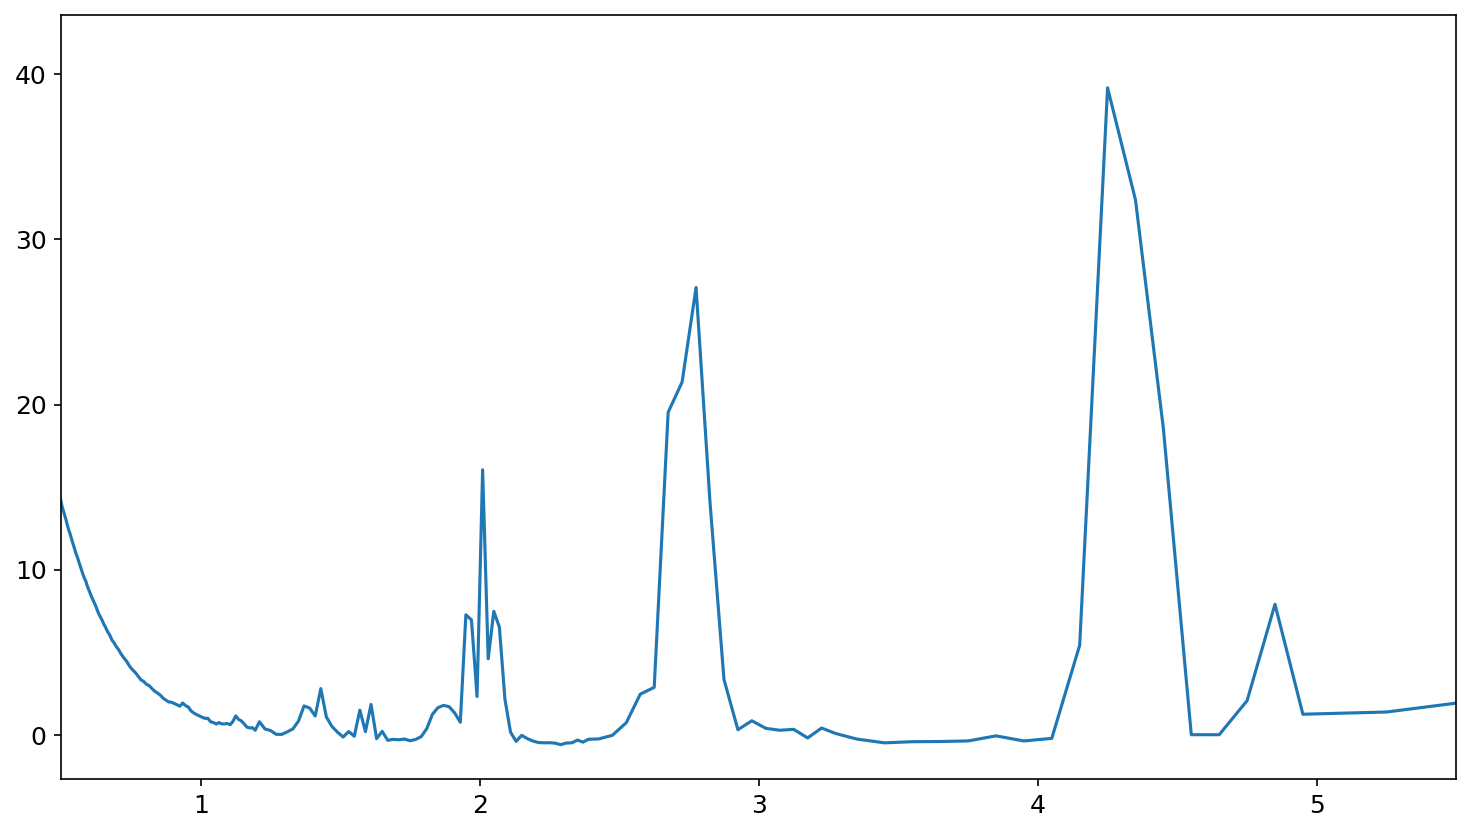

In [32]:
ax = plt.axes()
# ax.set_xscale("log")
ax.plot(x, atm_depth.data / 1e3)
ax.set_xlim(0.5, 5.5)

### Water vapour contribution check

In [10]:
suite_label = "llcs"
suite_prop = SUITE_LABELS[suite_label]
opt_label = "dsa_mcica_hybrid_extra"

sim_label = f"{suite_label}_{opt_label}"
top_label = f"{GLM_SUITE_ID}_synthobs_{sim_label}"
planet = suite_prop["planet"]
# const = init_const(planet, directory=mypaths.constdir)
# procdir = mypaths.sadir / top_label
procdir = (
    mypaths.home
    / "cylc-run"
    / f"{img_prefix}_{suite_label}_{opt_label}"
    / "share"
    / "cycle"
    / "1"
    / "base"
)
cl = load_data(procdir / "umglaa.ph*")

In [11]:
opt_prop = OPT_LABELS["dsa_mcica_hybrid"]
the_run = AtmoSim(
    cl,
    name=sim_label,
    planet=planet,
    const_dir=mypaths.constdir,
    timestep=cl[0].attributes.get("timestep", GLM_MODEL_TIMESTEP),
    model=um,
    vert_coord=None,
)
the_run.theta_levels = iris.cube.Cube(
    data=load_vert_lev(mypaths.home / "vert" / "vertlevs_L38_29t_9s_80km"),
    units="m",
    long_name="level_height",
)
the_run.spectral_file_sw = opt_prop["spectral_file_sw"]

In [18]:
planet_top_of_atmosphere = the_run.const.radius + the_run.theta_levels[-1]
stellar_constant_at_1_au = (
    the_run.const.solar_constant
    * (the_run.const.semi_major_axis / iris.cube.Cube(data=1, units="au")) ** 2
)
res = {}
vrbl_key = "with"
cube = the_run._cubes.extract_cube("m01s01i556")
cube.units = tex2cf_units("$W$ $m^{-2}$")

res[vrbl_key] = (
    calc_transmission_spectrum(
        cube,
        the_run.spectral_file_sw,
        stellar_constant_at_1_au,
        the_run.const.stellar_radius,
        planet_top_of_atmosphere,
        model=the_run.model,
    )
    ** 2
)

vrbl_key = "without"
cube = the_run._cubes.extract_cube("m01s01i756")
cube.units = tex2cf_units("$W$ $m^{-2}$")

res[vrbl_key] = (
    calc_transmission_spectrum(
        cube,
        the_run.spectral_file_sw,
        stellar_constant_at_1_au,
        the_run.const.stellar_radius,
        planet_top_of_atmosphere,
        model=the_run.model,
    )
    ** 2
)

In [19]:
x = res[vrbl_key].coord("spectral_band_centres").points * 1e6

(-5.0, 25.0)

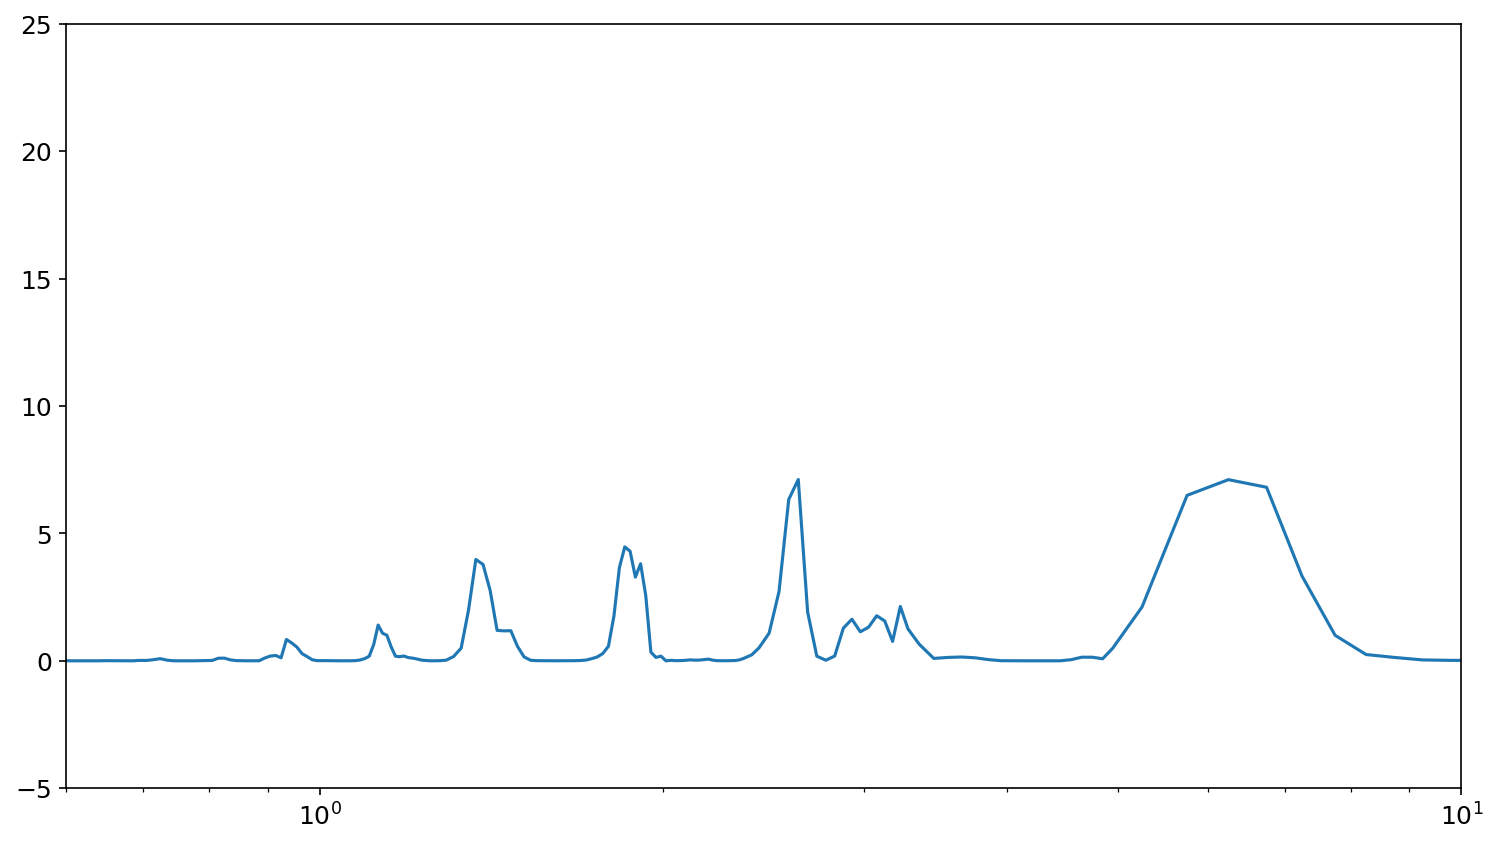

In [27]:
ax = plt.axes()
ax.plot(x, (res["with"].data - res["without"].data) * 1e6)
ax.set_xscale("log")
ax.set_xlim(0.6, 10)
ax.set_ylim(-5, 25)

In [29]:
time_reduce_func = lambda cube: isel(cube, um.t, 0)

In [30]:
a = time_reduce_func(the_run._cubes.extract_cube("m01s01i556"))
b = time_reduce_func(the_run._cubes.extract_cube("m01s01i756"))

6.2500005


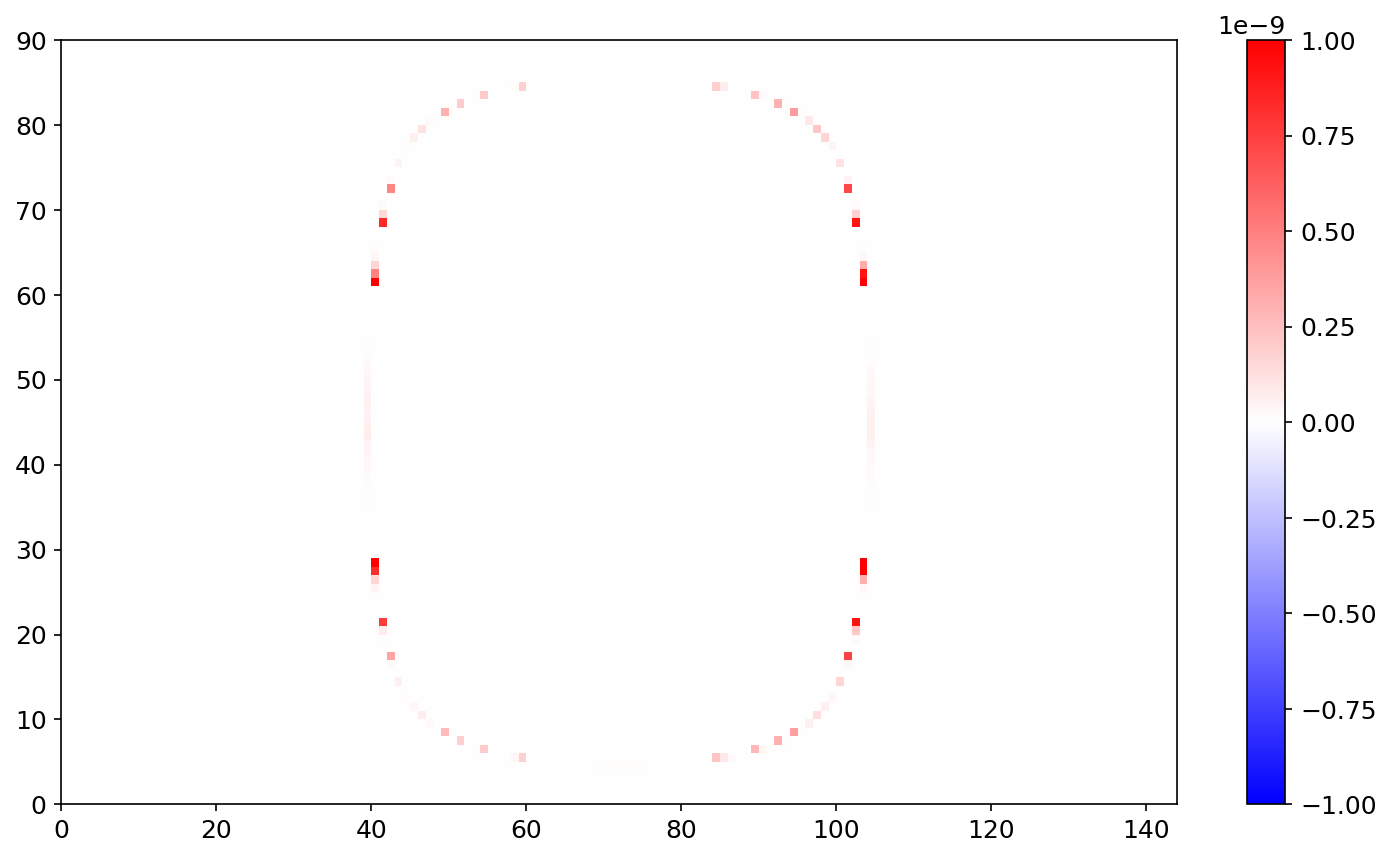

In [33]:
print(x[252])
plt.pcolormesh(b[252, ...].data - a[252, ...].data, vmin=-1e-9, vmax=1e-9, cmap="bwr")
plt.colorbar()

### Scaled cloud vs MCICA

Saved to ../../plots/sa/ch111/ch111_synthobs/ch111_synthobs__grcs_llcs__hsw_llw_scaled_cloud__trans_cloudy_trans_clear__diffs.png


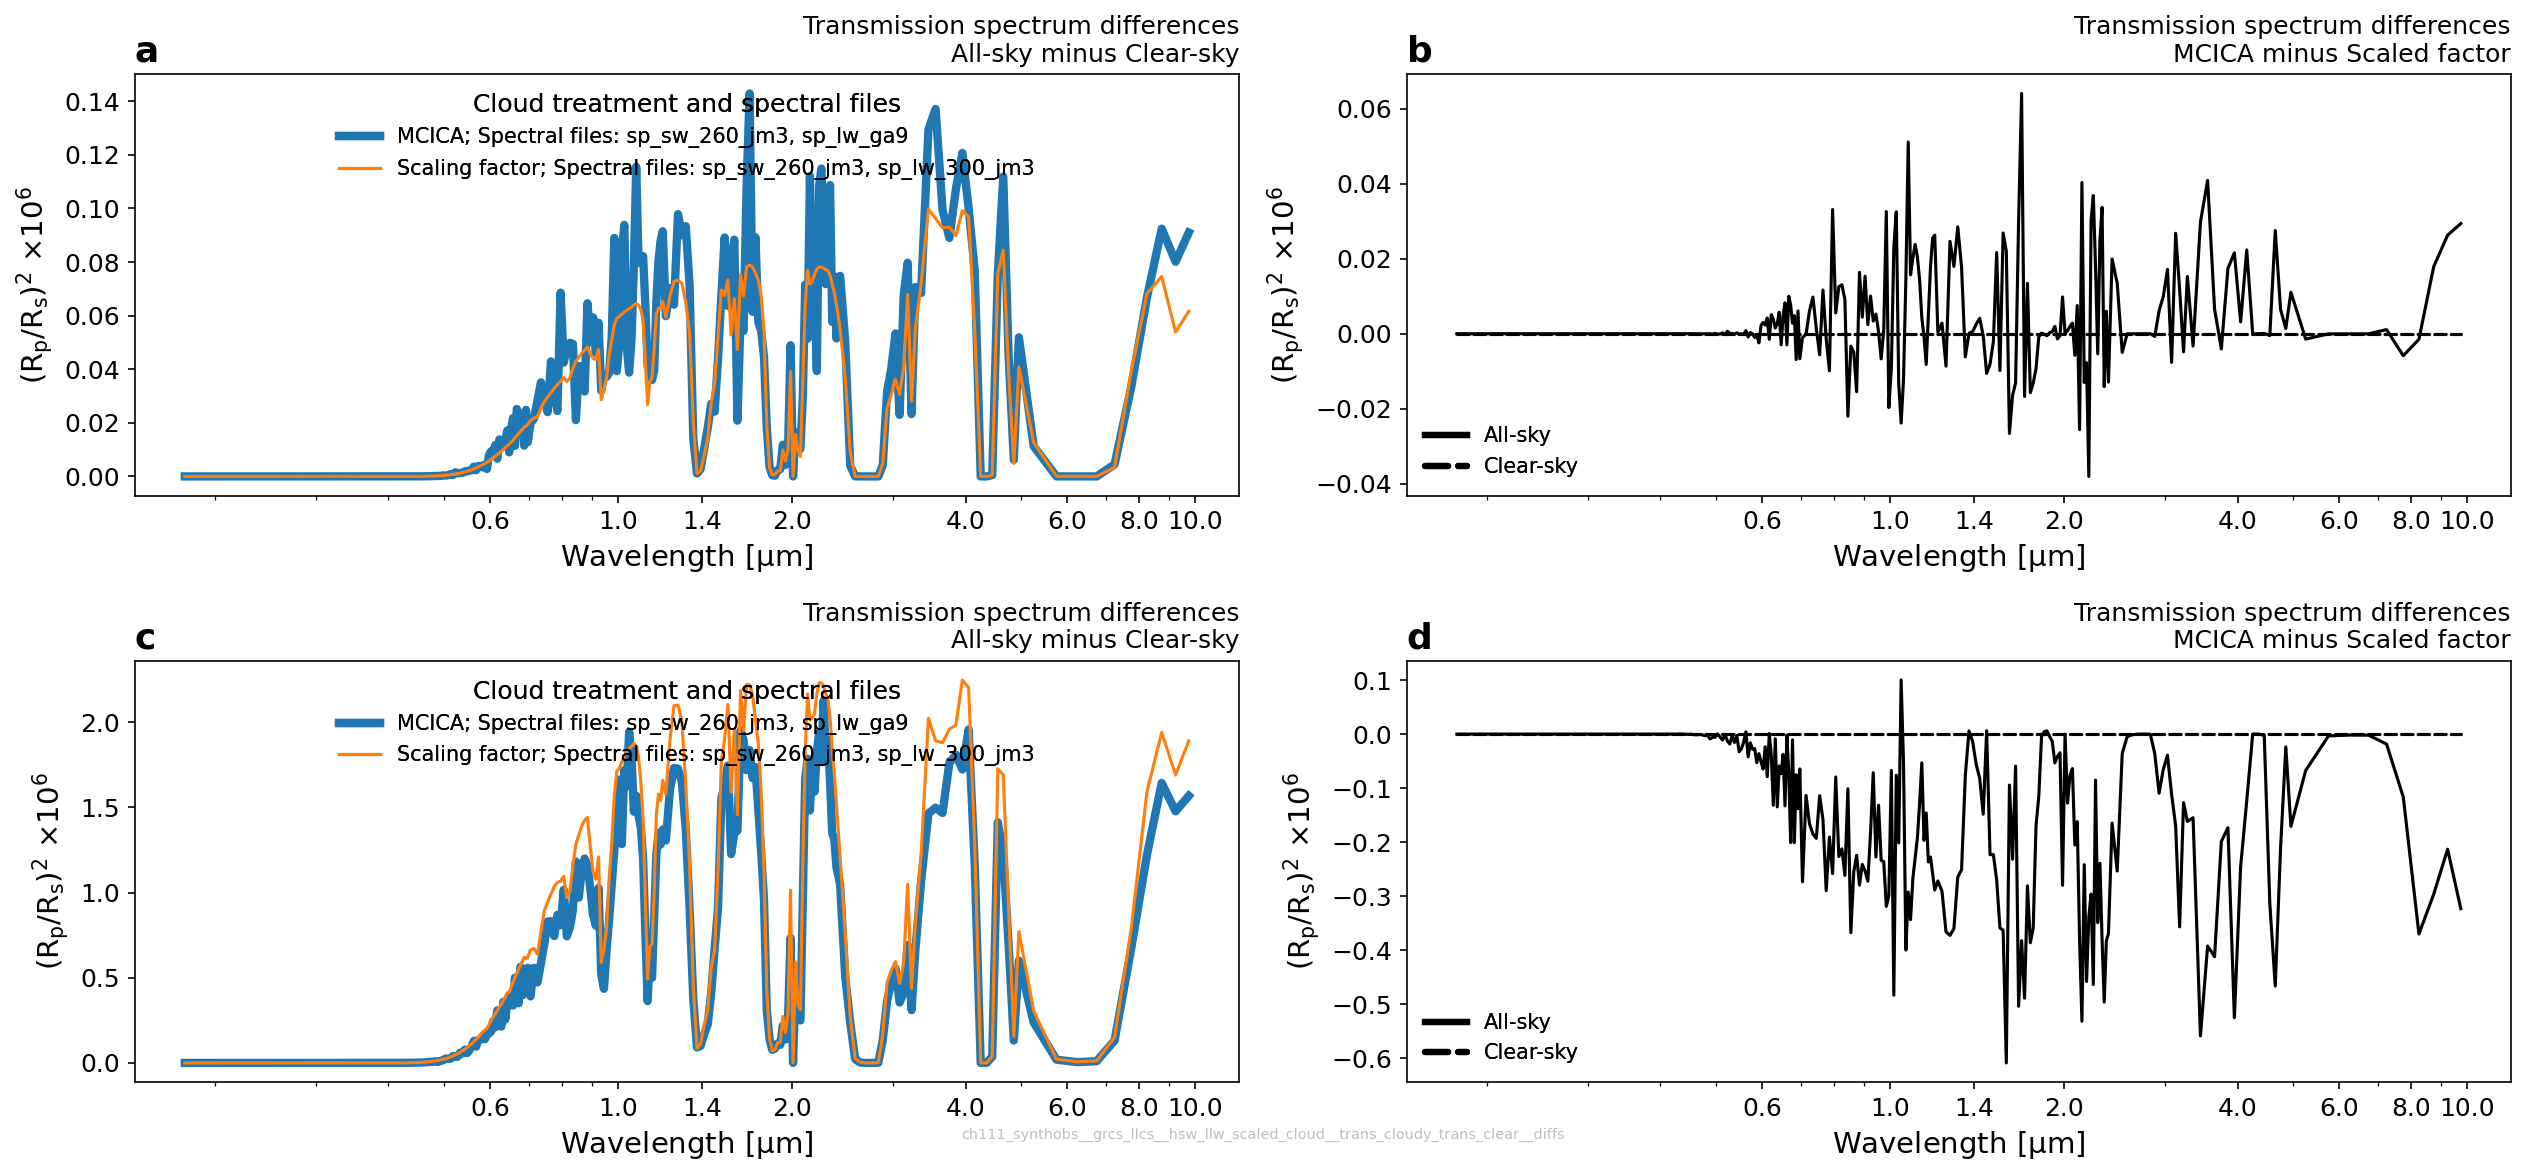

In [15]:
imgname = (
    f"{img_prefix}__{'_'.join(SUITE_LABELS.keys())}__"
    f"{'_'.join(OPT_LABELS.keys())}__{'_'.join(VRBL_PLOT.keys())}__diffs"
)
ncols = 2
nrows = len(SUITE_LABELS)
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8.5, nrows * 4), squeeze=False
)
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_xlabel("Wavelength [$\mu$m]")
    ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")
    xticks = np.concatenate(
        [
            [0.6, 1, 1.4],
            np.arange(2, 12, 2),
            # np.arange(12, 22, 2),
        ]
    )
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    # ax.set_xlim(xticks.min(), xticks.max())

for suite_label, axrow in zip(SUITE_LABELS.keys(), axs):
    ax = axrow[0]
    ax.set_title(
        "Transmission spectrum differences\nAll-sky minus Clear-sky",
        loc="right",
        size="medium",
    )
    for opt_label, opt_prop in OPT_LABELS.items():
        sim_label = f"{suite_label}_{opt_label}"
        cube = (
            RESULTS[sim_label]["trans_cloudy"] ** 2
            - RESULTS[sim_label]["trans_clear"] ** 2
        ) * 1e6
        x = cube.coord("spectral_band_centres").points * 1e6
        ax.plot(
            x,
            cube.data,
            **opt_prop["kw_plt"],
        )
    add_custom_legend(
        ax,
        {v["title"]: {"linestyle": "-", **v["kw_plt"]} for v in OPT_LABELS.values()},
        loc="upper center",
        # bbox_to_anchor=(0.5, 1.05),
        frameon=False,
        ncol=1,
        title="Cloud treatment and spectral files",
        fontsize="small",
    )

    ax = axrow[1]
    ax.set_title(
        "Transmission spectrum differences\nMCICA minus Scaled factor",
        loc="right",
        size="medium",
    )
    for i, (vrbl_key, vrbl_dict) in enumerate(VRBL_PLOT.items()):
        cube = (
            RESULTS[f"{suite_label}_hsw_llw"][vrbl_key] ** 2
            - RESULTS[f"{suite_label}_scaled_cloud"][vrbl_key] ** 2
        ) * 1e6
        x = cube.coord("spectral_band_centres").points * 1e6
        ax.plot(
            x,
            cube.data,
            color="k",
            **vrbl_dict["kw_plt"],
            # marker="o",
            # ms=3,
        )
    add_custom_legend(
        ax,
        {
            v["title"]: {"color": "k", "linewidth": 3, **v["kw_plt"]}
            for v in VRBL_PLOT.values()
        },
        loc="lower left",
        frameon=False,
        ncol=1,
        fontsize="small",
    )

fig.tight_layout()
figsave(fig, plotdir / imgname)

### Stellar spectrum

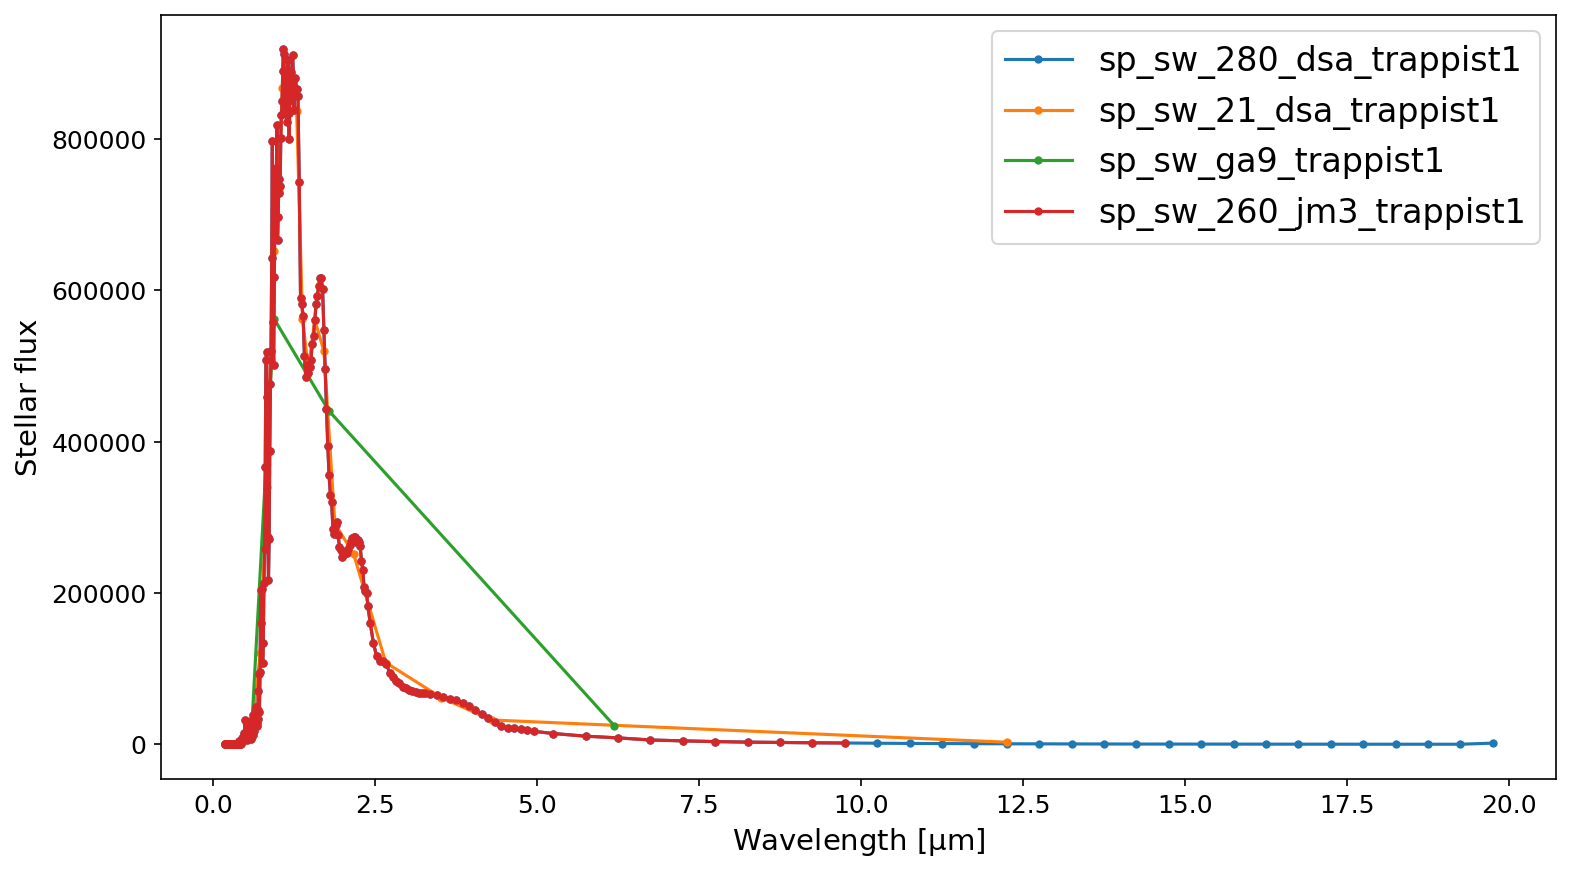

In [10]:
spectral_files = [
    mypaths.home / "spectral" / "trappist1" / "dsa_hr" / "sp_sw_280_dsa_trappist1",
    mypaths.home / "spectral" / "trappist1" / "dsa" / "sp_sw_21_dsa_trappist1",
    mypaths.home / "spectral" / "trappist1" / "ga9" / "sp_sw_ga9_trappist1",
    mypaths.home / "spectral" / "trappist1" / "ga9_ref" / "sp_sw_260_jm3_trappist1",
]

fig, ax = plt.subplots()
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Stellar flux")
for spectral_file in spectral_files:

    stellar_flux = read_normalized_stellar_flux(spectral_file)
    spectral_bands = read_spectral_bands(spectral_file)
    spectral_band_centres = 0.5 * (
        spectral_bands["lower_wavelength_limit"]
        + spectral_bands["upper_wavelength_limit"]
    )
    band_widths = (
        spectral_bands["upper_wavelength_limit"]
        - spectral_bands["lower_wavelength_limit"]
    )

    ax.plot(
        spectral_band_centres * 1e6,
        stellar_flux.data / band_widths,
        marker=".",
        label=spectral_file.name,
    )
ax.legend();

In [16]:
normalized_stellar_flux = read_normalized_stellar_flux(the_run.spectral_file_sw)

Text(0.0, 1.0, 'Spectral file: ga9_ref/sp_sw_260_jm3')

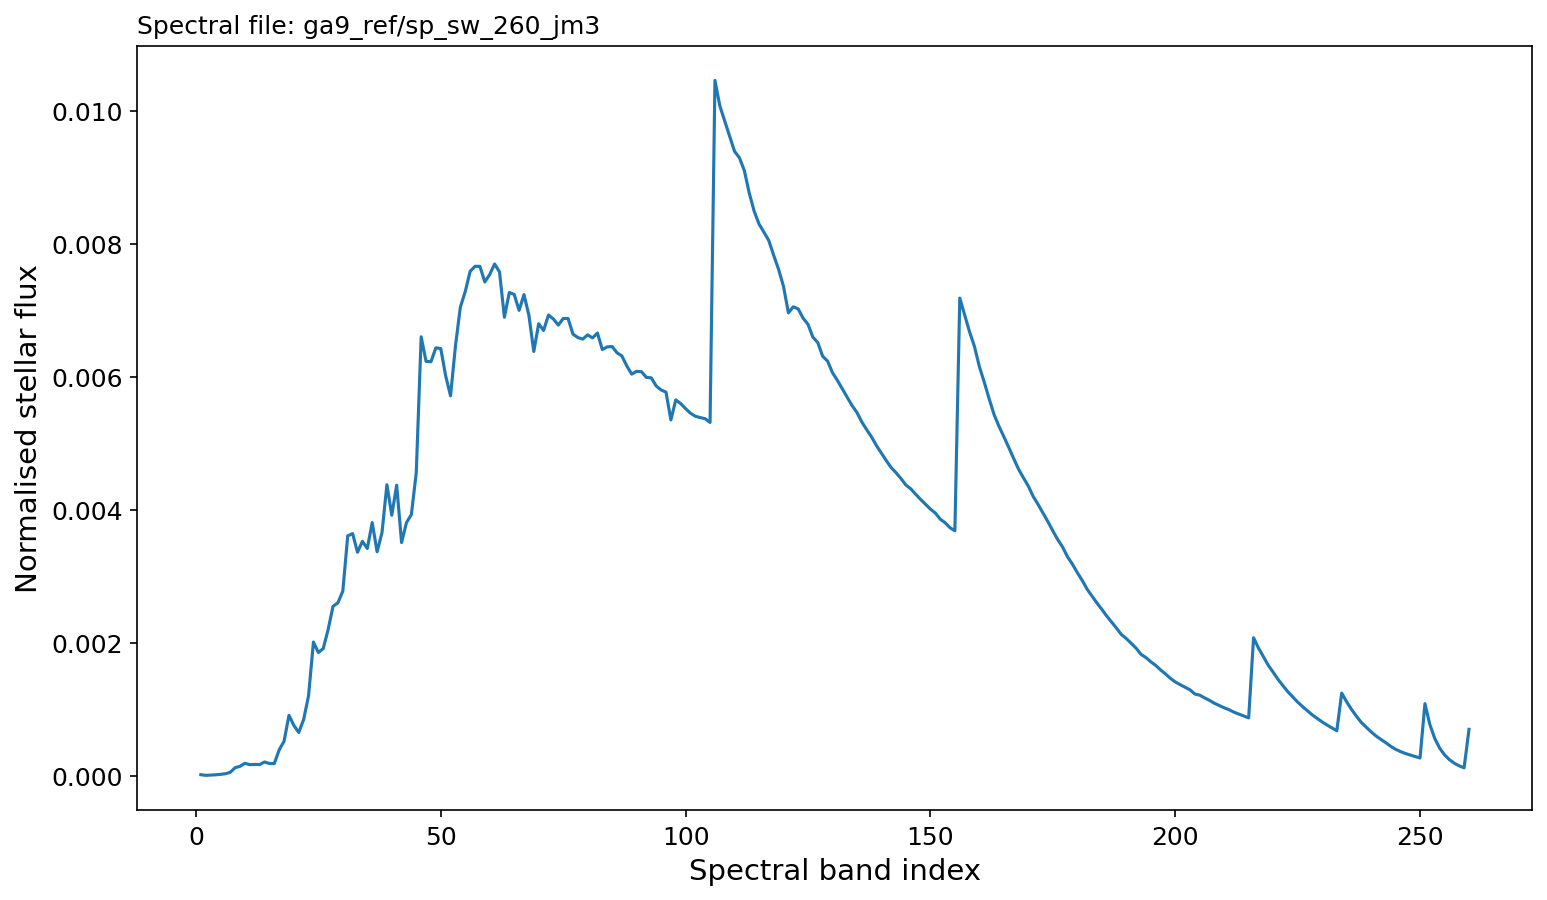

In [17]:
fig, ax = plt.subplots()
ax.plot(
    normalized_stellar_flux.coord("spectral_band_index").points,
    normalized_stellar_flux.data,
)
ax.set_xlabel("Spectral band index")
ax.set_ylabel("Normalised stellar flux")
ax.set_title(
    f"Spectral file: ga9_ref/{the_run.spectral_file_sw.name}", loc="left", size="medium"
)

# figsave(fig, plotdir / f"{spectral_file.name}__normalised_stellar_flux")

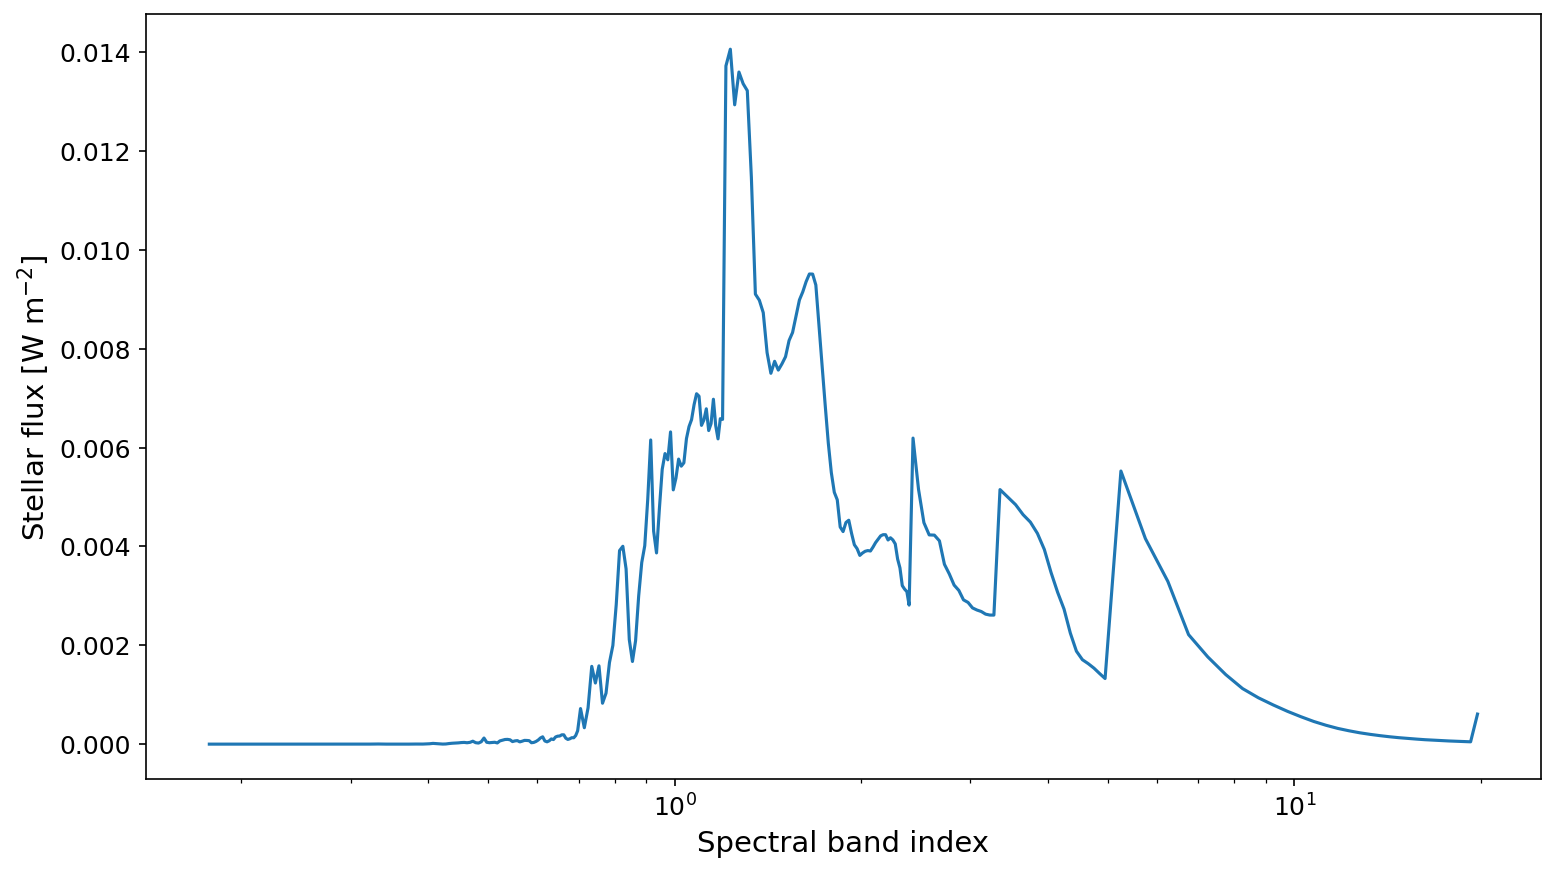

In [19]:
stellar_flux = calc_stellar_flux(the_run.spectral_file_sw, stellar_constant_at_1_au)

fig, ax = plt.subplots()
ax.plot(x, stellar_flux.data)
ax.set_xscale("log")
ax.set_xlabel("Spectral band index")
ax.set_ylabel("Stellar flux [W $m^{-2}$]");